In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using ",device)

You are using  cuda


In [8]:
train_data = np.load('data/face_alignment_training_images.npz', allow_pickle=True)
test_data = np.load('data/face_alignment_test_images.npz', allow_pickle=True)

train_imgs = train_data['images']
train_pts = train_data['points']
test_imgs_raw = test_data['images']

gray_imgs = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) if im.ndim == 3 else im for im in train_imgs])
test_imgs = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) if im.ndim == 3 else im for im in test_imgs_raw])

# Train Simple CNN on 70/30 validatiuon split
X_train_img, X_val_img, y_train_pts, y_val_pts = train_test_split(gray_imgs, train_pts, test_size=0.3, random_state=42)

# CNN variables
X_train_ten = torch.tensor(X_train_img / 255.0, dtype=torch.float32).unsqueeze(1)
y_train_ten = torch.tensor((y_train_pts / 255.0).reshape(y_train_pts.shape[0], -1), dtype=torch.float32)
X_val_ten = torch.tensor(X_val_img / 255.0, dtype=torch.float32).unsqueeze(1)
y_val_ten = torch.tensor((y_val_pts / 255.0).reshape(y_val_pts.shape[0], -1), dtype=torch.float32)

X_full_ten = torch.cat([X_train_ten, X_val_ten], dim=0)
y_full_ten = torch.cat([y_train_ten, y_val_ten], dim=0)
X_test_ten = torch.tensor(test_imgs / 255.0, dtype=torch.float32).unsqueeze(1)

# Scikit-learn variables
X_train_flat = X_train_img.reshape(X_train_img.shape[0], -1) / 255.0
y_train_flat = y_train_pts.reshape(y_train_pts.shape[0], -1)
X_val_flat = X_val_img.reshape(X_val_img.shape[0], -1) / 255.0
y_val_flat = y_val_pts.reshape(y_val_pts.shape[0], -1)

X_full_flat = np.concatenate([X_train_flat, X_val_flat], axis=0)
y_full_flat = np.concatenate([y_train_flat, y_val_flat], axis=0)
X_test_flat = test_imgs.reshape(test_imgs.shape[0], -1) / 255.0

print(f"Number of training images: {len(gray_imgs)}")
print(f"Number of test images: {len(test_imgs)}")

train_sizes = set([im.shape for im in gray_imgs])
print(f"Unique training image sizes: {train_sizes}")

test_sizes = set([im.shape for im in test_imgs])
print(f"Unique test image sizes: {test_sizes}")


Number of training images: 2811
Number of test images: 554
Unique training image sizes: {(256, 256)}
Unique test image sizes: {(256, 256)}


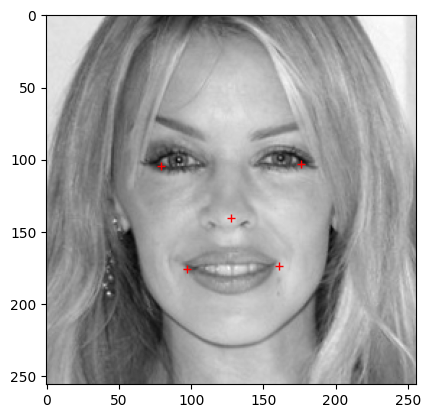

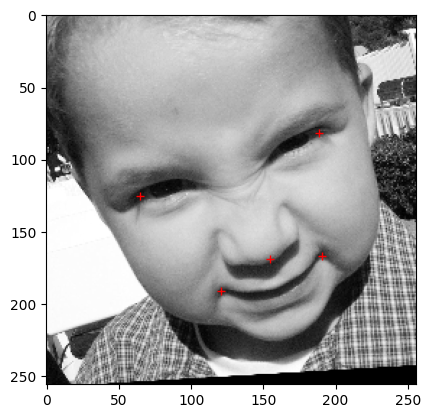

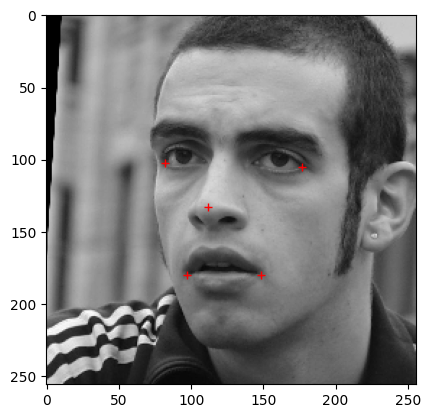

In [5]:
def visualise_pts(img, pts):
    plt.imshow(img, cmap='gray')
    plt.plot(pts[:, 0], pts[:, 1], '+r')
    plt.show()

for i in range(3):
    idx = np.random.randint(0, gray_imgs.shape[0])
    visualise_pts(gray_imgs[idx, ...], train_pts[idx, ...])

In [4]:
# Training Ridge model
ridge_alphas = np.logspace(-3, 3, 7)
ridge_model = RidgeCV(alphas=ridge_alphas).fit(X_train_flat, y_train_flat)
print("Ridge regression model trained.")

Ridge regression model trained.


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, output_dim):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                           # Downsample by factor of 2 (from 256x256 to 128x128)

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                           # Downsample to 64x64

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                           # Downsample to 32x32

            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()

        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()                              # Output normalized between 0 and 1
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [10]:
full_load = DataLoader(TensorDataset(X_full_ten, y_full_ten), batch_size=32, shuffle=True)
train_load = DataLoader(TensorDataset(X_train_ten, y_train_ten), batch_size=32, shuffle=True)
val_load = DataLoader(TensorDataset(X_val_ten, y_val_ten), batch_size=32)
output_dim = y_train_ten.shape[1]

In [11]:
def train_model(model, train_loader, val_loader=None, epochs=600, lr=0.0002):   #Already tired lr of 0.0003 not worth it
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)        #Do not use 1e-5, model starts to overfit
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    pred = model(X_batch)
                    val_loss += criterion(pred, y_batch).item()

            # This adjusts learning rate if validation loss plateaus
            scheduler.step(val_loss)
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}")

    return model

In [12]:
# Train Simple CNN on training set
print("Simple CNN")
simple_cnn = SimpleCNN(output_dim)
simple_cnn = train_model(simple_cnn, train_load, val_load, epochs=450, lr=0.0002)


Simple CNN
Epoch 1/450 | Train Loss: 0.1413 | Val Loss: 0.0377
Epoch 2/450 | Train Loss: 0.0739 | Val Loss: 0.0247
Epoch 3/450 | Train Loss: 0.0463 | Val Loss: 0.0209
Epoch 4/450 | Train Loss: 0.0385 | Val Loss: 0.0159
Epoch 5/450 | Train Loss: 0.0339 | Val Loss: 0.0173
Epoch 6/450 | Train Loss: 0.0319 | Val Loss: 0.0150
Epoch 7/450 | Train Loss: 0.0286 | Val Loss: 0.0136
Epoch 8/450 | Train Loss: 0.0286 | Val Loss: 0.0138
Epoch 9/450 | Train Loss: 0.0280 | Val Loss: 0.0130
Epoch 10/450 | Train Loss: 0.0249 | Val Loss: 0.0137
Epoch 11/450 | Train Loss: 0.0253 | Val Loss: 0.0128
Epoch 12/450 | Train Loss: 0.0245 | Val Loss: 0.0137
Epoch 13/450 | Train Loss: 0.0253 | Val Loss: 0.0121
Epoch 14/450 | Train Loss: 0.0237 | Val Loss: 0.0116
Epoch 15/450 | Train Loss: 0.0243 | Val Loss: 0.0117
Epoch 16/450 | Train Loss: 0.0250 | Val Loss: 0.0111
Epoch 17/450 | Train Loss: 0.0239 | Val Loss: 0.0120
Epoch 18/450 | Train Loss: 0.0229 | Val Loss: 0.0125
Epoch 19/450 | Train Loss: 0.0241 | Val Loss

In [13]:
def visualise_comparison(img, pred_pts, true_pts):
    plt.imshow(img, cmap='gray')
    plt.scatter(pred_pts[:, 0], pred_pts[:, 1], c='r', label='Predicted', marker='.')
    plt.scatter(true_pts[:, 0], true_pts[:, 1], c='g', label='Ground Truth', marker='+', facecolors='none')
    plt.legend()
    plt.axis('off')
    plt.show()

In [14]:
simple_cnn.eval()
with torch.no_grad():
    # GPU VRAM Error if you don't have a powerful GPU, so always have batch size on for safe execution
    # lower batch size if 32 is still giving error, or just invest in a good GPU, Q3 2025 trust
    batch_size = 32
    val_pred_loader = DataLoader(TensorDataset(X_val_ten), batch_size=batch_size, shuffle=False)

    val_preds = []
    for X_batch_list in val_pred_loader:
        X_batch = X_batch_list[0].to(device) # DataLoader returns a list of tensors
        batch_preds = simple_cnn(X_batch).cpu().numpy()
        val_preds.append(batch_preds)

    val_preds = np.concatenate(val_preds, axis=0)
    val_preds *= 256
targets = y_val_ten.cpu().numpy() * 256

In [15]:
def euclid_dist(pred_pts, gt_pts):

  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [16]:
# Reshape to (num_samples, num_points, 2)
preds_reshaped = val_preds.reshape(-1, int(val_preds.shape[1] / 2), 2)
targets_reshaped = targets.reshape(-1, int(targets.shape[1] / 2), 2)


# Compute mean Euclidean error per image for CNN
c_err = []
for i in range(len(val_preds)):
    pred_pts = val_preds[i].reshape(-1, 2)
    true_pts = y_val_pts[i].reshape(-1, 2)
    dist = euclid_dist(pred_pts, true_pts)
    c_err.append(np.mean(dist))
cmean_err = np.mean(c_err)
print(f"Simple CNN Validation Mean Error: {cmean_err:.2f} pixels")


Simple CNN Validation Mean Error: 5.01 pixels


In [17]:
ridge_preds_val = ridge_model.predict(X_val_flat)
ridge_preds_reshaped = ridge_preds_val.reshape(-1, int(ridge_preds_val.shape[1] / 2), 2)
y_val_reshaped = y_val_flat.reshape(-1, int(y_val_flat.shape[1] / 2), 2)


r_err = []
for i in range(len(ridge_preds_reshaped)):
    dist = euclid_dist(ridge_preds_reshaped[i], y_val_reshaped[i])
    r_err.append(np.mean(dist))
rmean_err = np.mean(r_err)
print(f"RidgeCV Mean Error (Euclidean): {rmean_err:.2f} pixels")

RidgeCV Mean Error (Euclidean): 7.36 pixels



Image 206 — Simple CNN


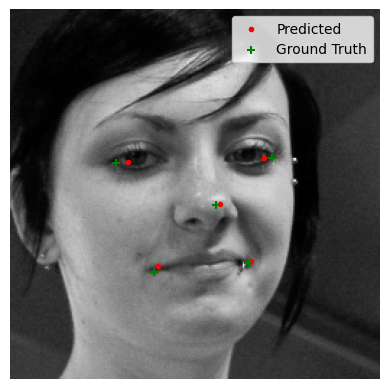

Image 206 — RidgeCV


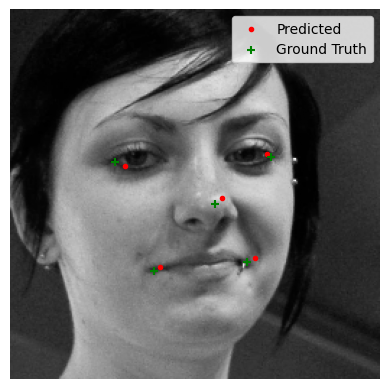


Image 518 — Simple CNN


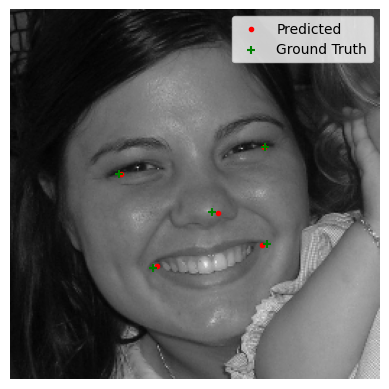

Image 518 — RidgeCV


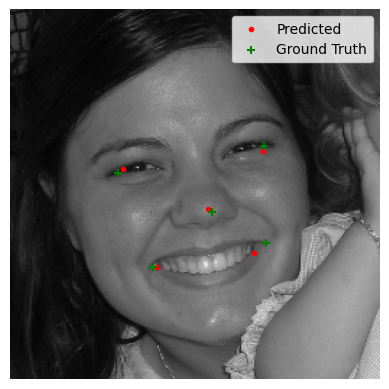


Image 211 — Simple CNN


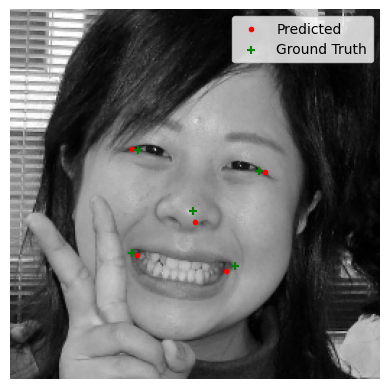

Image 211 — RidgeCV


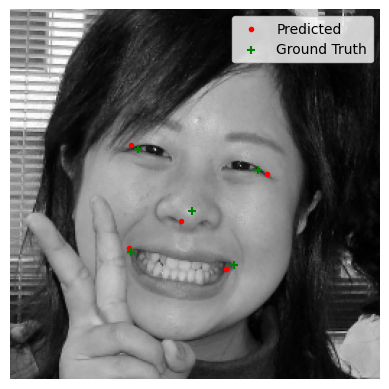


Image 288 — Simple CNN


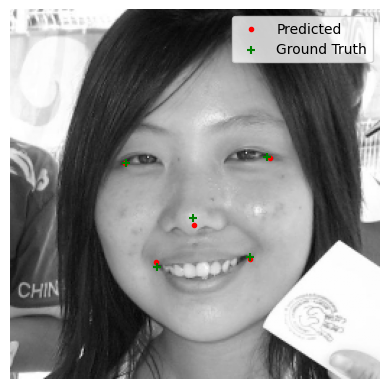

Image 288 — RidgeCV


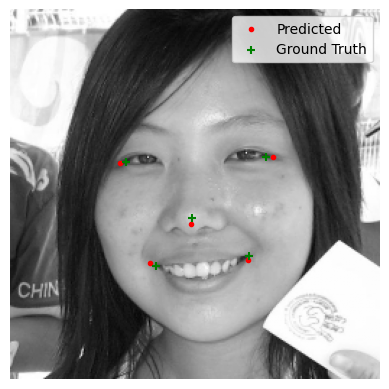


Image 474 — Simple CNN


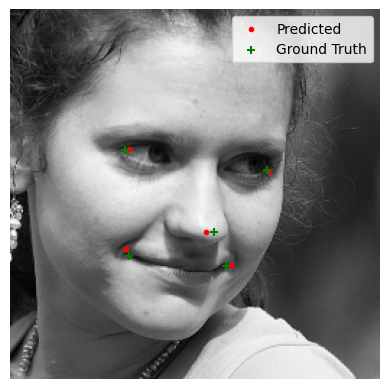

Image 474 — RidgeCV


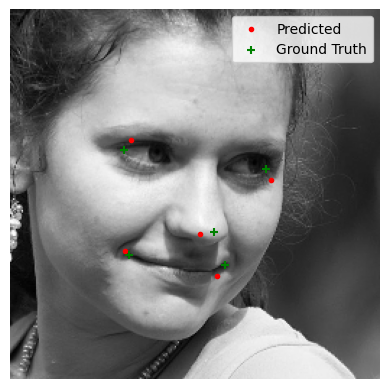


Image 414 — Simple CNN


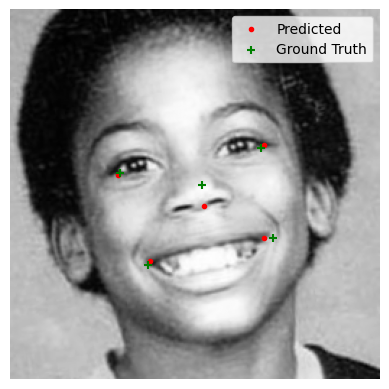

Image 414 — RidgeCV


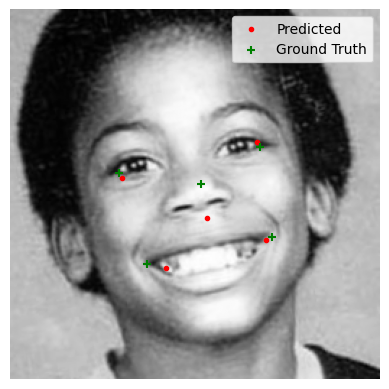


Image 526 — Simple CNN


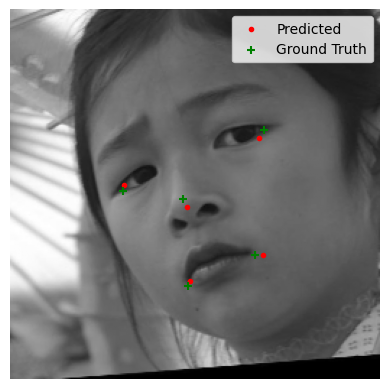

Image 526 — RidgeCV


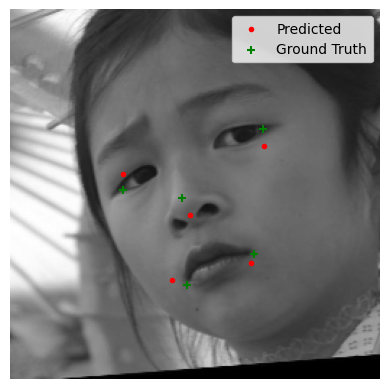


Image 208 — Simple CNN


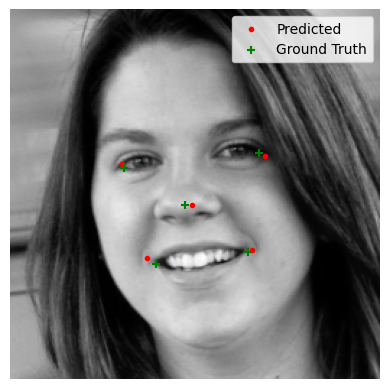

Image 208 — RidgeCV


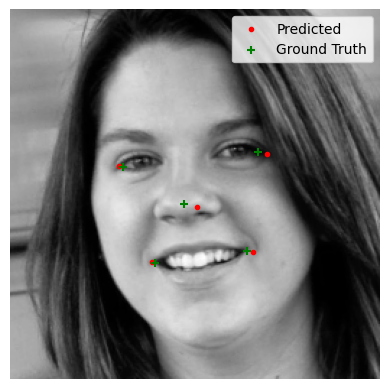


Image 227 — Simple CNN


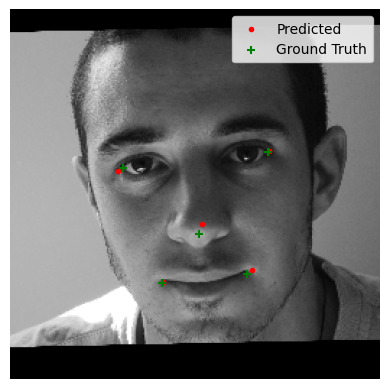

Image 227 — RidgeCV


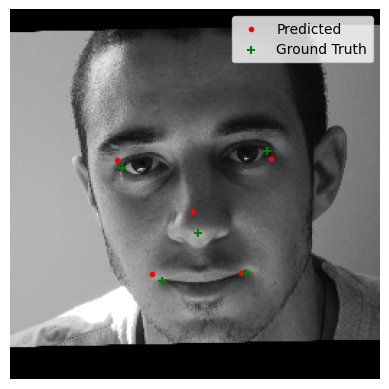


Image 798 — Simple CNN


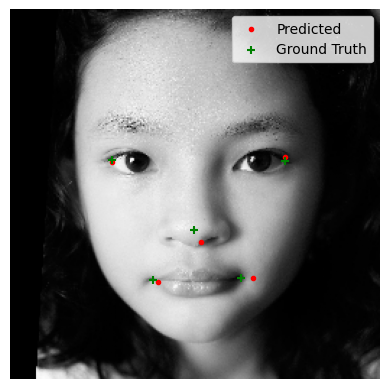

Image 798 — RidgeCV


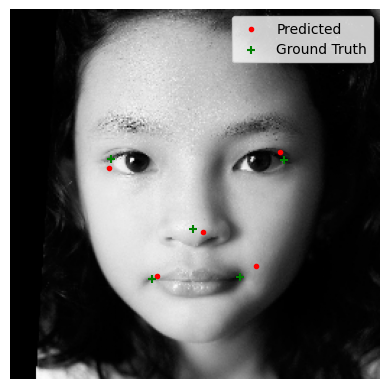

In [19]:
indices = np.random.choice(len(X_val_img), size=10, replace=False)
for i in indices:
    print(f"\nImage {i} — Simple CNN")
    visualise_comparison(X_val_img[i], val_preds[i].reshape(-1, 2), targets[i].reshape(-1, 2))

    print(f"Image {i} — RidgeCV")
    visualise_comparison(X_val_img[i], ridge_preds_val[i].reshape(-1, 2), y_val_flat[i].reshape(-1, 2))

In [18]:
# Comparison between CNN and Ridge
# CNN does better so now it will train on the full training set and then will predict points on test set
print(f" Overall CNN mean error: {cmean_err:.2f} pixels")
print(f" Overall Ridge mean error: {rmean_err:.2f} pixels")

 Overall CNN mean error: 5.01 pixels
 Overall Ridge mean error: 7.36 pixels


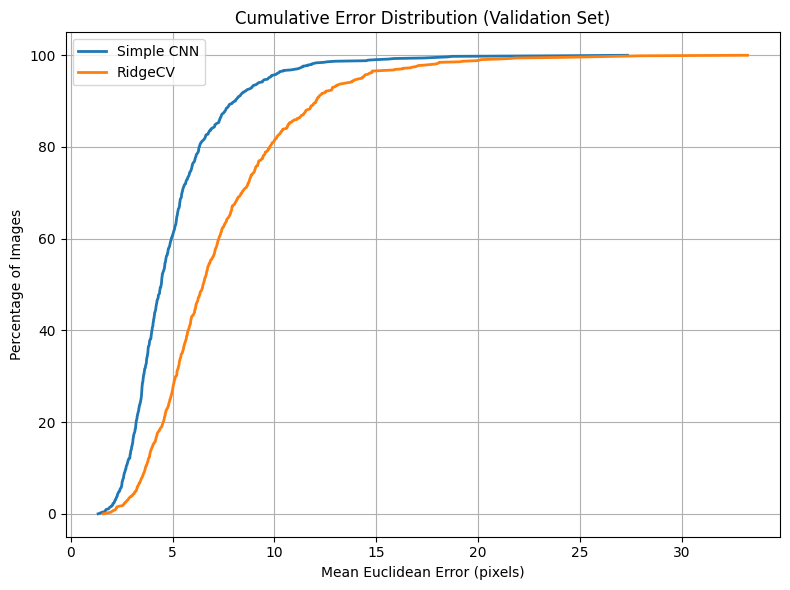

In [21]:
# Cumulative Error Distribution plot
sorted_cnn_errors = np.sort(c_err)
sorted_ridge_errors = np.sort(r_err)

cnn_cumulative = np.linspace(0, 100, len(sorted_cnn_errors))
ridge_cumulative = np.linspace(0, 100, len(sorted_ridge_errors))


plt.figure(figsize=(8, 6))
plt.plot(sorted_cnn_errors, cnn_cumulative, label='Simple CNN', linewidth=2)
plt.plot(sorted_ridge_errors, ridge_cumulative, label='RidgeCV', linewidth=2)

plt.xlabel("Mean Euclidean Error (pixels)")
plt.ylabel("Percentage of Images")
plt.title("Cumulative Error Distribution (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
#Train Simple CNN on Full set
simple_cnn = train_model(simple_cnn, full_load, epochs=500, lr=0.0002)

Epoch 1/500 | Train Loss: 0.0326
Epoch 2/500 | Train Loss: 0.0211
Epoch 3/500 | Train Loss: 0.0207
Epoch 4/500 | Train Loss: 0.0204
Epoch 5/500 | Train Loss: 0.0208
Epoch 6/500 | Train Loss: 0.0199
Epoch 7/500 | Train Loss: 0.0204
Epoch 8/500 | Train Loss: 0.0209
Epoch 9/500 | Train Loss: 0.0204
Epoch 10/500 | Train Loss: 0.0200
Epoch 11/500 | Train Loss: 0.0201
Epoch 12/500 | Train Loss: 0.0208
Epoch 13/500 | Train Loss: 0.0210
Epoch 14/500 | Train Loss: 0.0206
Epoch 15/500 | Train Loss: 0.0214
Epoch 16/500 | Train Loss: 0.0205
Epoch 17/500 | Train Loss: 0.0204
Epoch 18/500 | Train Loss: 0.0201
Epoch 19/500 | Train Loss: 0.0209
Epoch 20/500 | Train Loss: 0.0202
Epoch 21/500 | Train Loss: 0.0206
Epoch 22/500 | Train Loss: 0.0204
Epoch 23/500 | Train Loss: 0.0205
Epoch 24/500 | Train Loss: 0.0203
Epoch 25/500 | Train Loss: 0.0201
Epoch 26/500 | Train Loss: 0.0204
Epoch 27/500 | Train Loss: 0.0205
Epoch 28/500 | Train Loss: 0.0199
Epoch 29/500 | Train Loss: 0.0205
Epoch 30/500 | Train Lo

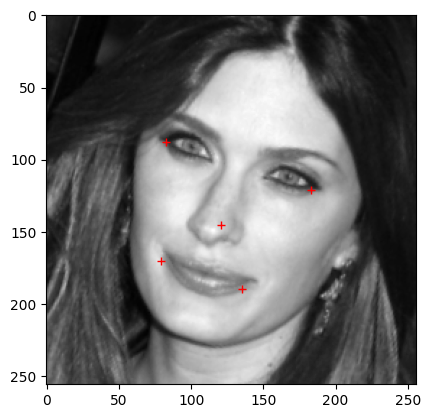

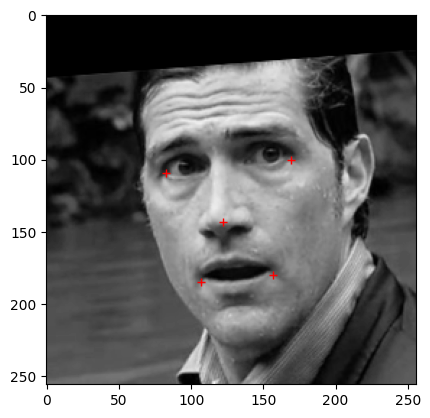

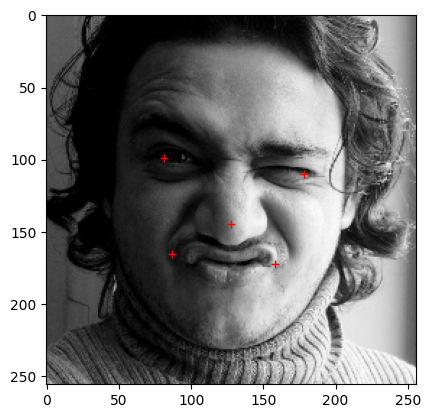

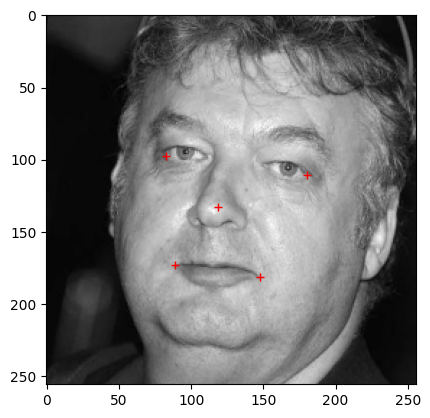

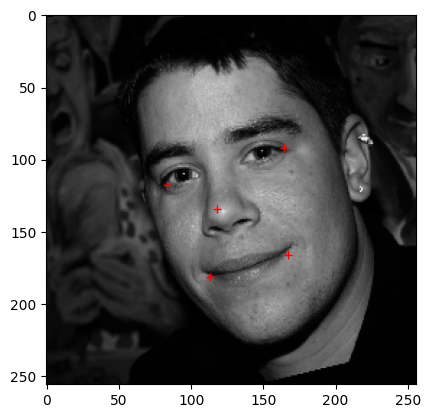

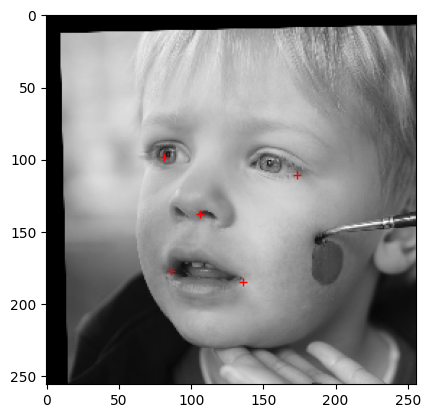

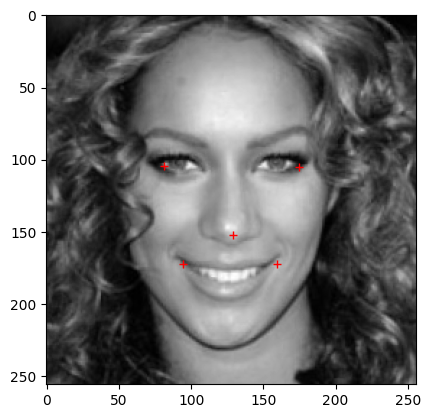

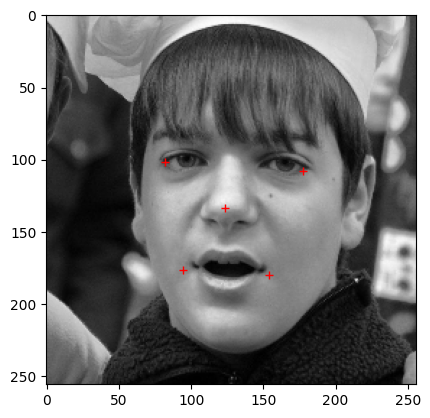

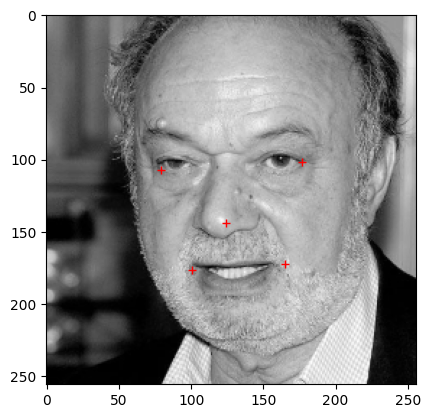

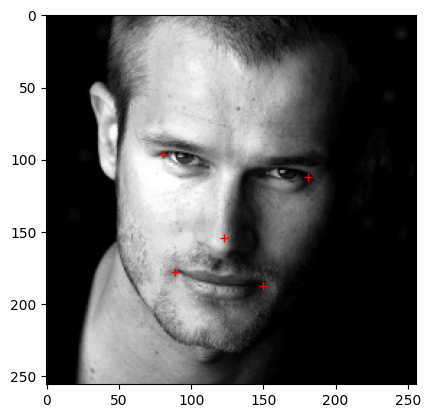

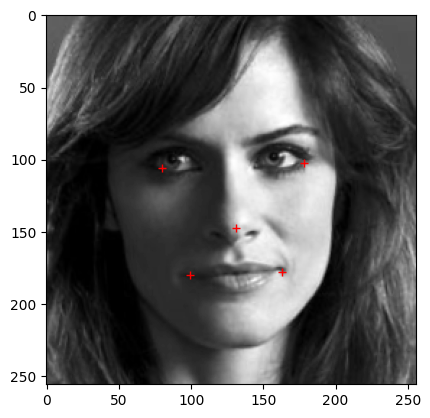

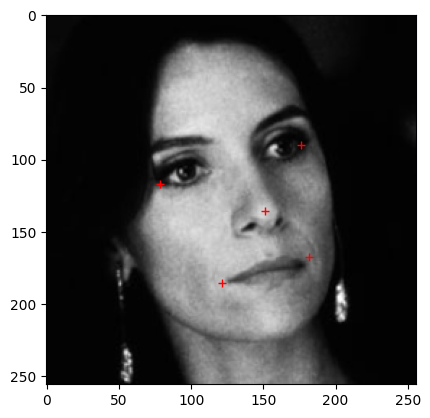

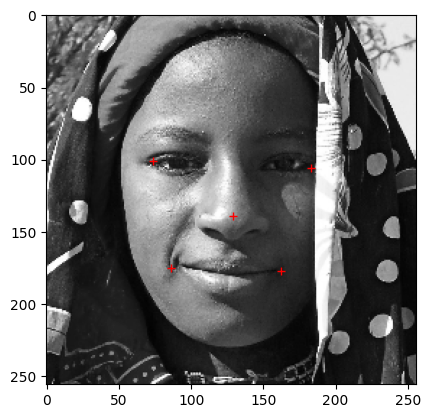

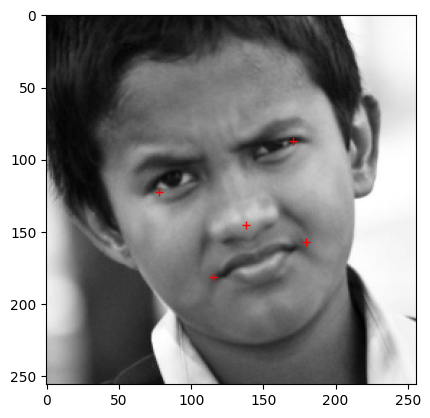

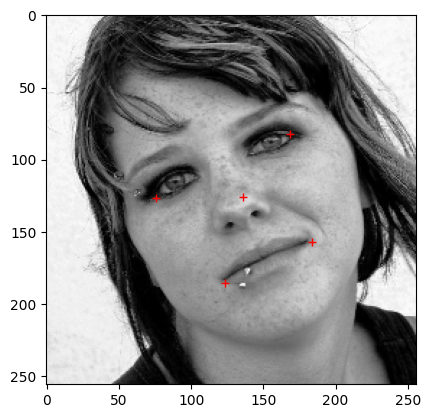

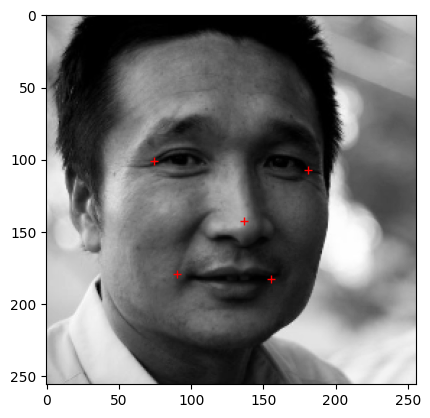

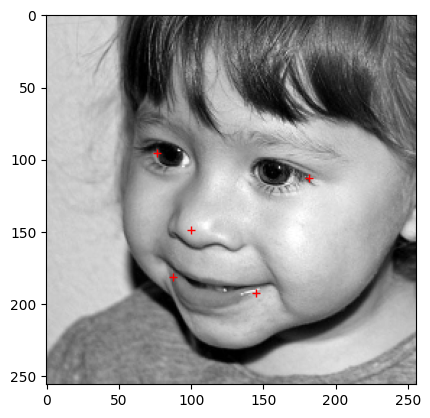

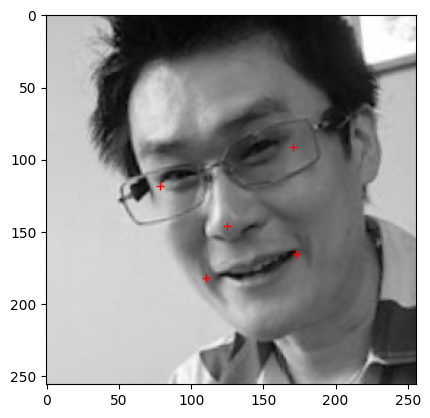

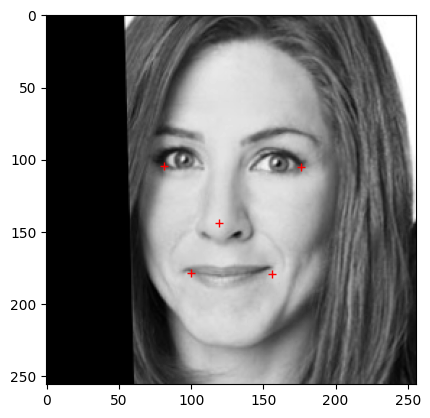

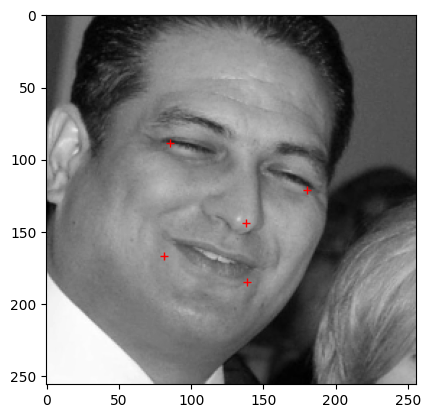

In [20]:
simple_cnn.eval()
with torch.no_grad():
    test_preds = simple_cnn(X_test_ten.to(device)).cpu().numpy()

test_indices = np.random.choice(len(test_imgs), size=20, replace=False)

for i in test_indices:
    img = test_imgs[i]
    spts = test_preds[i].reshape(-1, 2) * 256
    visualise_pts(img, spts)


In [ ]:
# Just incase whoever wants to save this model and use it for themselves
torch.save(simple_cnn.state_dict(), 'simple_cnn_model.pth')

In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==5*2, 'wrong number of points provided. There should be 5 points with 2 values (x,y) per point'
    np.savetxt(location + '/results_task2.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [ ]:
test_preds *= 256
cnn_test_points = test_preds.reshape(-1, 5, 2)

# Saving on Colab as well as downloading it on your system
save_as_csv(cnn_test_points, location = 'results')

In [ ]:
# Checking if the points are being placed in correctly in the CSV

csv_points = np.loadtxt('results/results_task2.csv', delimiter=',')
csv_points_reshaped = csv_points.reshape(-1, 5, 2)
num_images = csv_points_reshaped.shape[0]
indices = np.random.choice(num_images, size=10, replace=False)

for i in indices:
    img = test_imgs[i]
    pts = csv_points_reshaped[i]
    print(f"Image {i}")
    visualise_pts(img, pts)